In [26]:
# #!/usr/bin/env python

# """Notebook for rapid prompt-based annotation. Box to mask using Segment Anything Model"""

# __author__      = "Sahib Julka <sahib.julka@uni-passau.de>"
# __copyright__   = "GPL"


In [27]:
import torch
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import sys
sys.path.append('../src')
import pandas as pd

import cv2
import numpy as np
import supervision as sv
from os.path import expanduser

In [30]:
home = expanduser("~")
main_path = home+"/Active-Learning-Segmentation/"
dataframes_path = main_path + "data/dataframes/"
sam_path = main_path + "sam/sam_vit_h_4b8939.pth"
notebooks_path = main_path + "scripts/notebooks/"
expirements_path = main_path+"expirements/"

In [31]:
# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH =sam_path

In [32]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_predictor = SamPredictor(sam)

In [33]:
df = pd.read_csv(dataframes_path+"lung_df_test.csv")

In [34]:
# i = np.random.randint(1, len(df))
i=1
import supervision as sv
images = []
gt_masks = []
for idx in range(20):
    images.append(cv2.resize(np.load(df["images"][idx], allow_pickle=True), (256, 256), interpolation=cv2.INTER_CUBIC))
    gt_masks.append(cv2.resize(np.load(df["masks"][idx], allow_pickle=True), (256, 256), interpolation=cv2.INTER_CUBIC))
# gt_mask = np.sum(gt_mask, axis=2)
# sv.plot_images_grid(
#     images=[image, gt_mask],
#     grid_size=(1, 2),
#     titles=['image', 'gt_mask']
# )

In [10]:
# print(resized_image.shape)

In [38]:
def getBoxes(image, gt_mask):
    contours, _ = cv2.findContours(gt_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        box = np.array([x, y, x+w, y+h])
        cnts.append(box)
    boxes = torch.Tensor(np.array(cnts)).to(DEVICE)
    print(boxes)
    transformed_boxes = mask_predictor.transform.apply_boxes_torch(boxes, image.shape[:2])
    print(transformed_boxes)
    return transformed_boxes                                                                                                                           
    

In [69]:
idx = 0
boxes = getBoxes(images[idx], gt_masks[idx])

tensor([[118., 202., 128., 212.]], device='cuda:0')
tensor([[472., 808., 512., 848.]], device='cuda:0')


In [81]:
mask_predictor.set_image(images[idx])
masks, box_scores, logits = mask_predictor.predict_torch(
    point_coords = None,
    point_labels = None,
    boxes=boxes,
    mask_input=torch.Tensor(gt_masks[idx]).view(1, gt_masks[idx].shape[0], gt_masks[idx].shape[1]).cuda(),
    multimask_output=False
)

In [82]:
masks = masks.cpu().numpy()
box_scores = box_scores.cpu().numpy()
print("box_scores shape :", box_scores.shape)
best_matches = []
for i in range(len(box_scores)):
    best_matches .append(masks[i][np.argmax(box_scores[i])])
    
mask = sum(best_matches)
mask = np.array(mask>0, dtype=np.uint8)

box_scores shape : (1, 1)


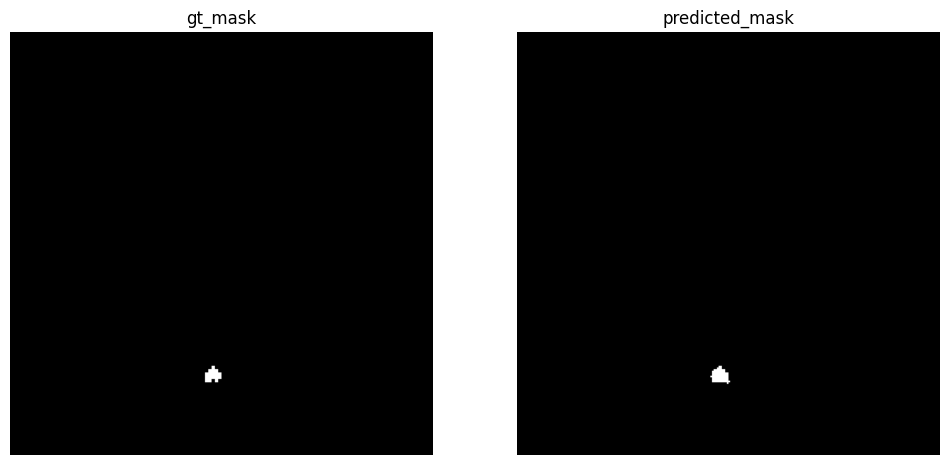

In [83]:
sv.plot_images_grid(
images=[gt_masks[idx], mask],
grid_size=(1, 2),
titles=['gt_mask', 'predicted_mask']
)

In [84]:
# boxes = []
# for img, gt_mask in zip(images, gt_masks):
#     boxes.append(getBoxes(image, gt_mask))

In [13]:
# len(boxes)

In [21]:
predicted_masks = []
index = 0
skipped = []
for img, gt_mask in zip(images, gt_masks):
    print("Sample : ", index)
    contours, _ = cv2.findContours(gt_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        box = np.array([x, y, x+w, y+h])
        # box = np.array([y, x, y+h, x+w])
        cnts.append(box)
    boxes = torch.Tensor(np.array(cnts)).to(DEVICE)
    if len(boxes)==0:
        print("No boxes found")
        skipped.append(index)
        index+=1
        continue

    print("Boxes shape: ", boxes.shape)
    mask_predictor.set_image(img)
    
    transformed_boxes = mask_predictor.transform.apply_boxes_torch(boxes, img.shape[:2])
    print("transformed_boxes shape: ", transformed_boxes.shape)
    
    masks, box_scores, logits = mask_predictor.predict_torch(
        point_coords = None,
        point_labels = None,
        boxes=transformed_boxes,
        multimask_output=False
    )
    print("Masks shape :", masks.shape)
    masks = masks.cpu().numpy()
    box_scores = box_scores.cpu().numpy()
    print("box_scores shape :", box_scores.shape)
    best_matches = []
    for i in range(len(box_scores)):
        best_matches .append(masks[i][np.argmax(box_scores[i])])
        
    mask = sum(best_matches)
    mask = np.array(mask>0, dtype=np.uint8)
    
    np.save(df["oracle"][index],mask.squeeze())
    index+=1
    
    print("predicted mask shape : ", mask.shape)
    predicted_masks.append(mask)

    print("===============")
    # mask = masks.sum(axis=0).cpu().numpy()[0]

Sample :  0
Boxes shape:  torch.Size([1, 4])
transformed_boxes shape:  torch.Size([1, 4])
Masks shape : torch.Size([1, 1, 256, 256])
box_scores shape : (1, 1)
predicted mask shape :  (256, 256)
Sample :  1
Boxes shape:  torch.Size([1, 4])
transformed_boxes shape:  torch.Size([1, 4])
Masks shape : torch.Size([1, 1, 256, 256])
box_scores shape : (1, 1)
predicted mask shape :  (256, 256)
Sample :  2
Boxes shape:  torch.Size([1, 4])
transformed_boxes shape:  torch.Size([1, 4])
Masks shape : torch.Size([1, 1, 256, 256])
box_scores shape : (1, 1)
predicted mask shape :  (256, 256)
Sample :  3
Boxes shape:  torch.Size([1, 4])
transformed_boxes shape:  torch.Size([1, 4])
Masks shape : torch.Size([1, 1, 256, 256])
box_scores shape : (1, 1)
predicted mask shape :  (256, 256)
Sample :  4
Boxes shape:  torch.Size([1, 4])
transformed_boxes shape:  torch.Size([1, 4])
Masks shape : torch.Size([1, 1, 256, 256])
box_scores shape : (1, 1)
predicted mask shape :  (256, 256)
Sample :  5
Boxes shape:  torc

In [23]:
for i in skipped:
    images.pop(i)
    gt_masks.pop(i)

0


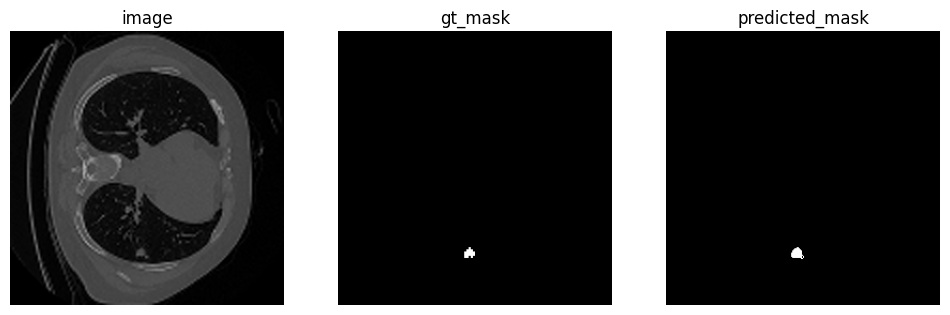

1


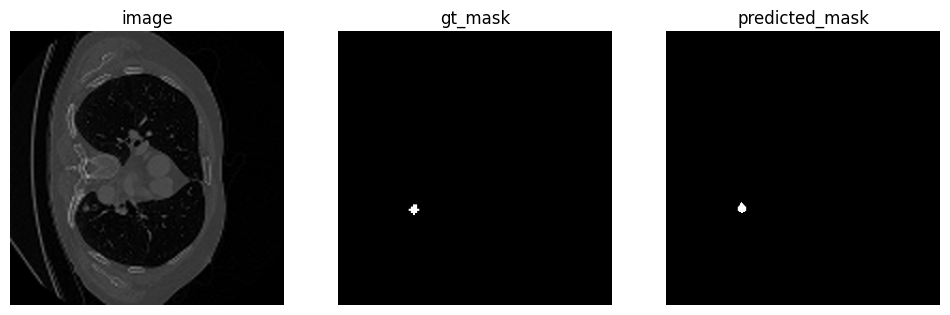

2


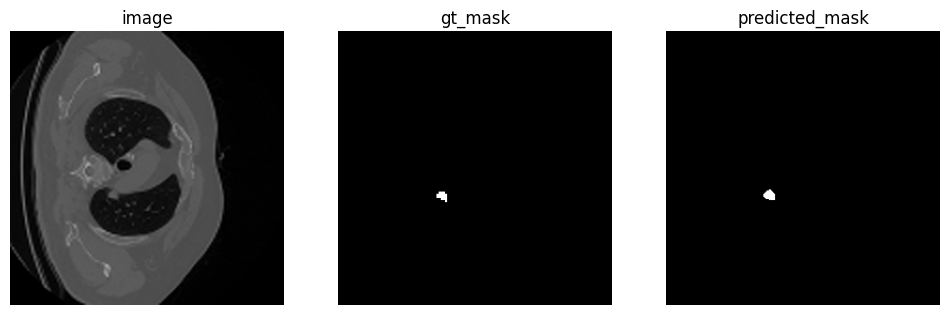

3


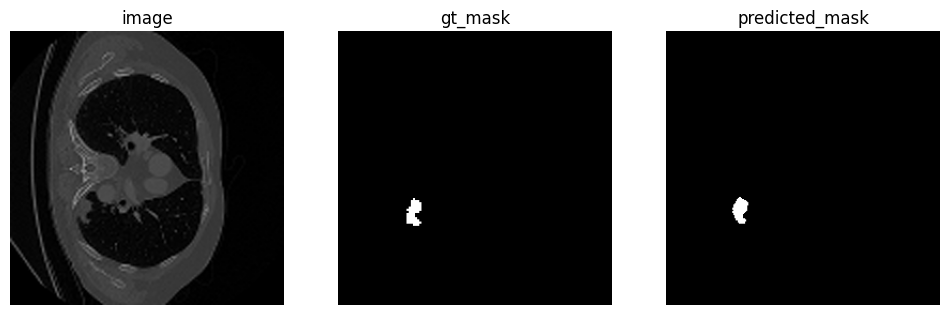

4


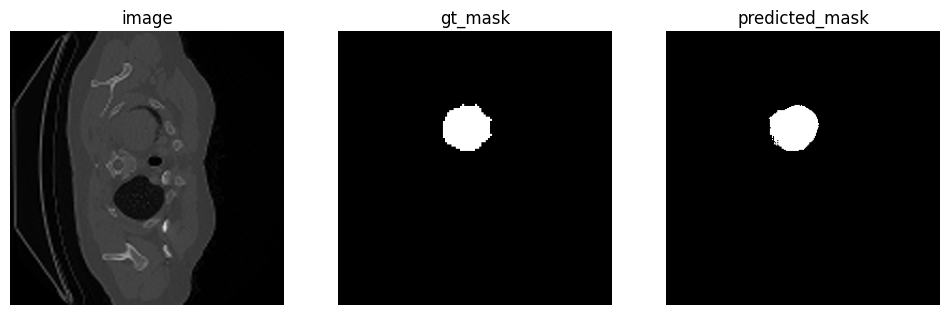

5


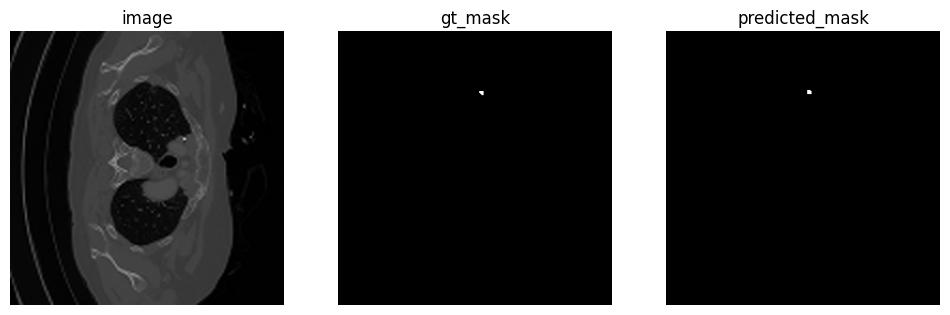

6


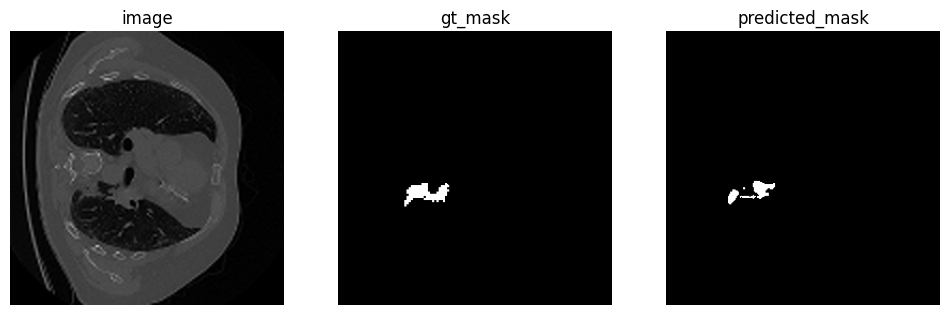

7


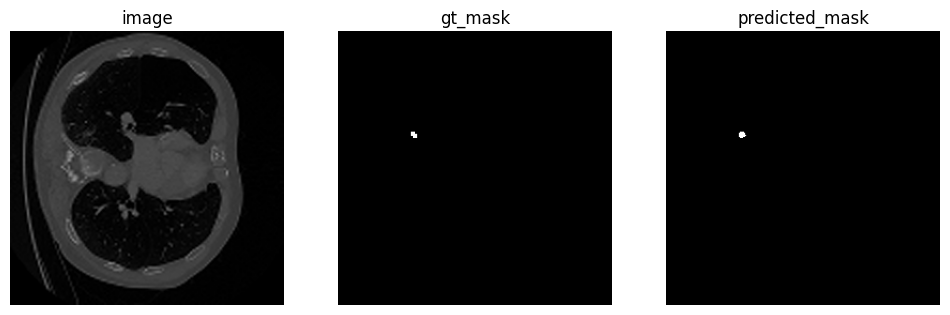

8


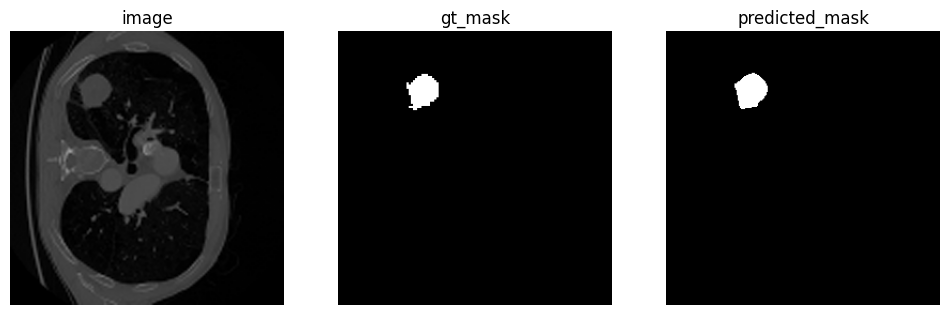

9


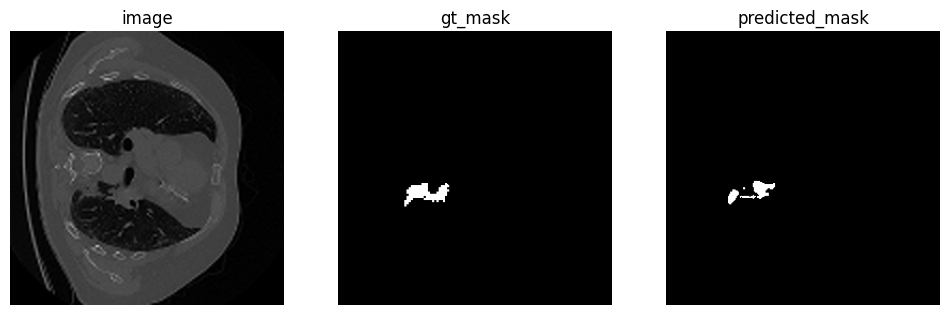

10


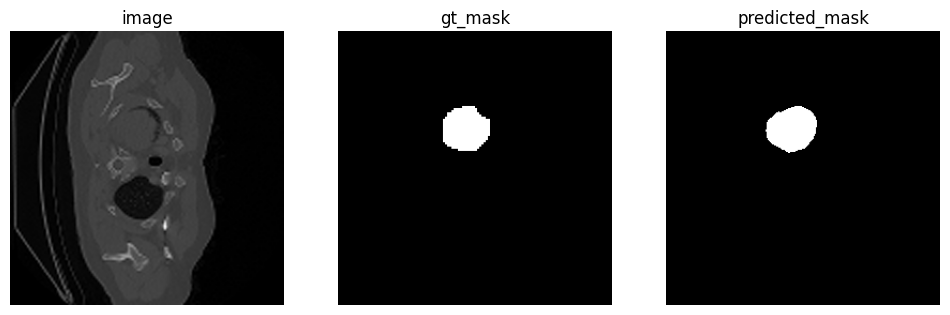

11


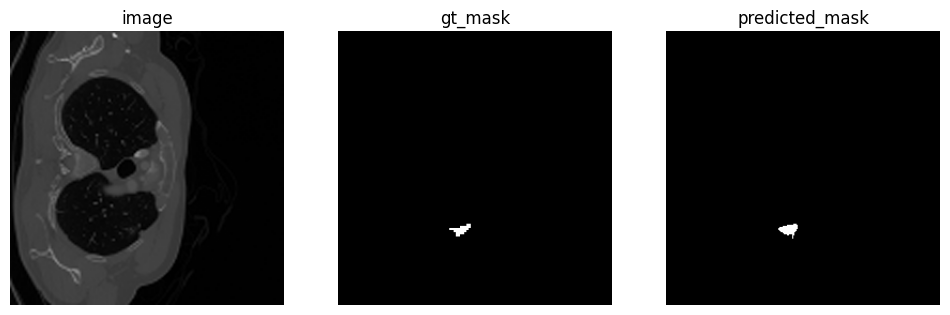

12


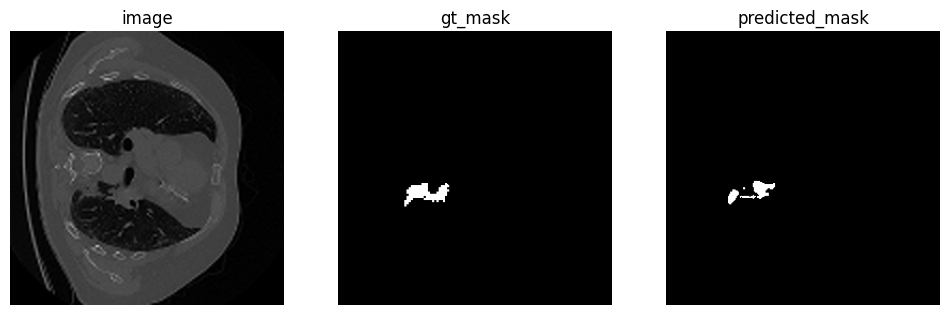

13


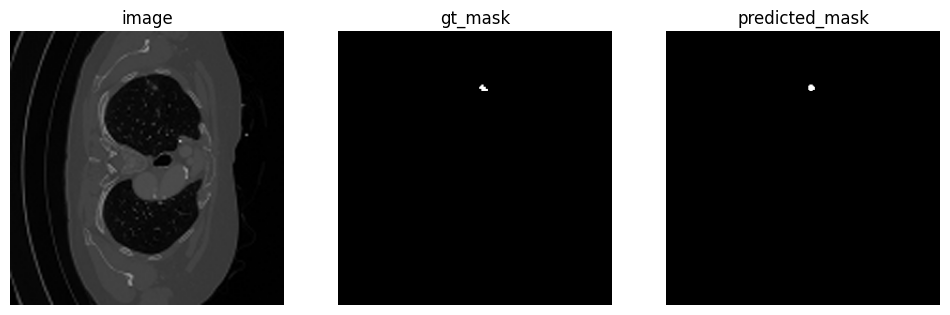

14


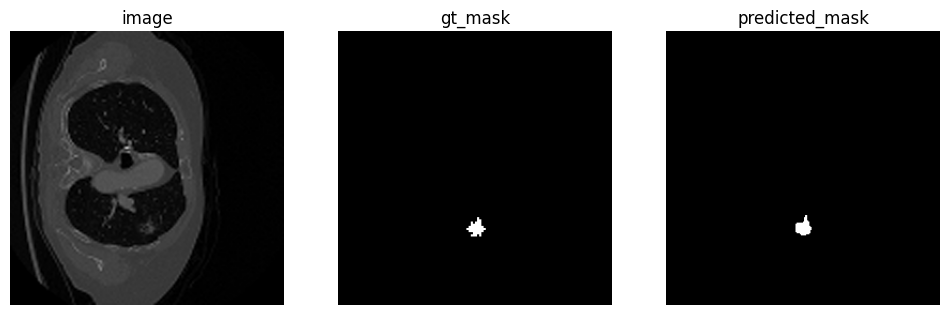

15


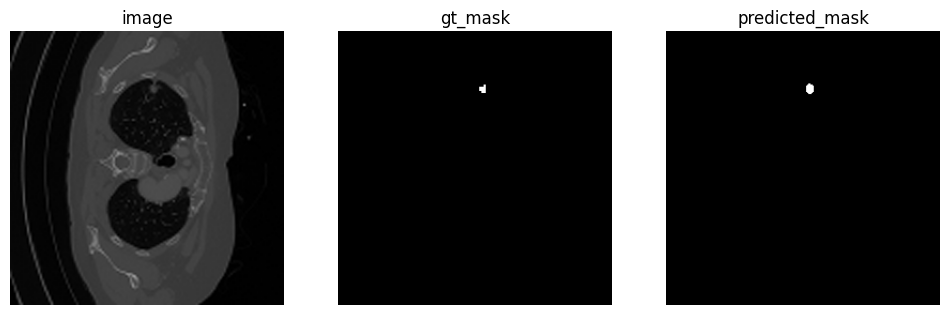

16


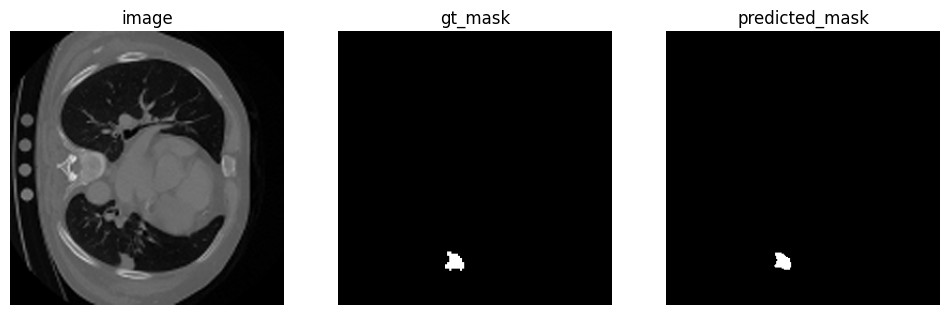

17


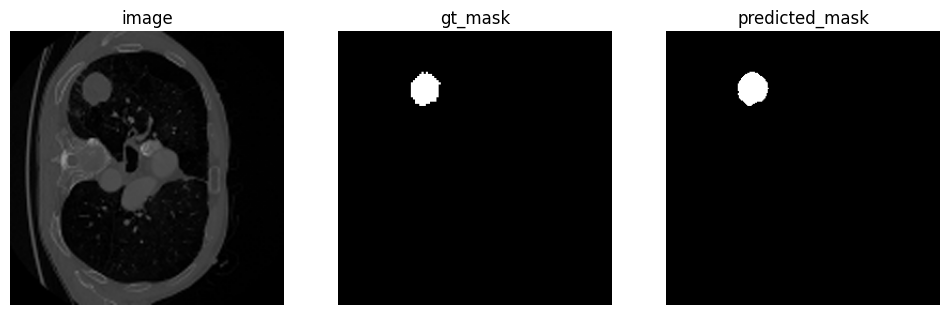

18


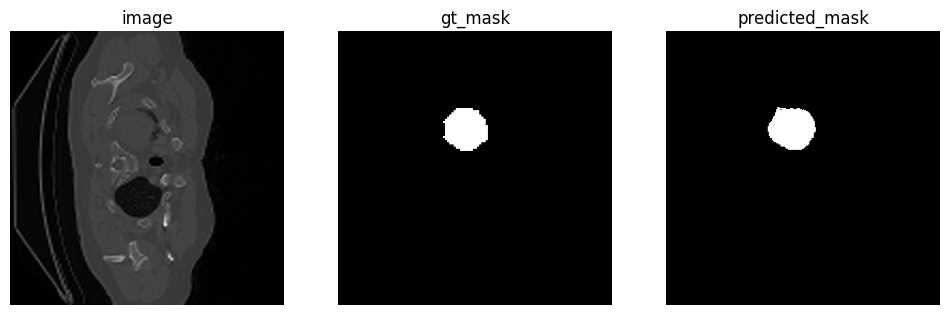

In [24]:
for i in range(len(predicted_masks)):
    print(i)
    sv.plot_images_grid(
    images=[images[i], gt_masks[i], predicted_masks[i]],
    grid_size=(1, 3),
    titles=['image', 'gt_mask', 'predicted_mask']
)

In [14]:
# masks = masks.cpu().numpy()
# box_scores = box_scores.cpu().numpy()
# best_matches = []
# for i in range(len(box_scores)):
#     best_matches .append(masks[i][np.argmax(box_scores[i])])
    
# mask = sum(best_matches)
# mask = np.array(mask>0, dtype=np.uint8)



In [15]:
mask.shape

(256, 256)

In [16]:
# idx = 2
# mask = gt_masks[idx]
# mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup="INDEX")

# detections = sv.Detections(
#     xyxy=sv.mask_to_xyxy(masks=cv2.cvtColor(mask*255,cv2.COLOR_GRAY2RGB)),
#     mask=cv2.cvtColor(mask*255,cv2.COLOR_GRAY2RGB)
# )
# detections = detections[detections.area == np.max(detections.area)]

# segmented_image = mask_annotator.annotate(scene=cv2.cvtColor(mask*255,cv2.COLOR_GRAY2RGB).copy(), detections=detections)

# sv.plot_images_grid(
#     images=[mask, segmented_image],
#     grid_size=(1, 2),
#     titles=['source image', 'segmented image']
# )

In [17]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='white', facecolor=(0,0,0,0), lw=2))    

In [48]:
gt_mask=gt_masks[14]

In [49]:
contours, _ = cv2.findContours(gt_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = []
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    box = np.array([x, y, x+w, y+h])
    cnts.append(box)
input_box = np.array(cnts)


In [50]:
input_box

array([[120, 174, 138, 192]])

In [51]:
boxes = torch.Tensor(np.array(cnts)).to(DEVICE)
mask_predictor.set_image(images[17])

transformed_boxes = mask_predictor.transform.apply_boxes_torch(boxes, img.shape[:-1])

In [52]:
print()

In [53]:
img.shape[:2]

(256, 256)

In [54]:
transformed_boxes

tensor([[480., 696., 552., 768.]], device='cuda:0')

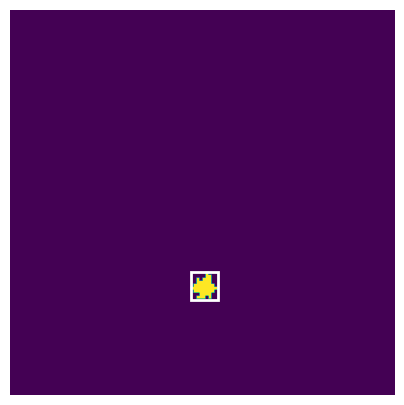

In [55]:
plt.figure(figsize=(5, 5))
plt.imshow(gt_mask)
show_box(input_box[0], plt.gca())
plt.axis('off')
plt.show()

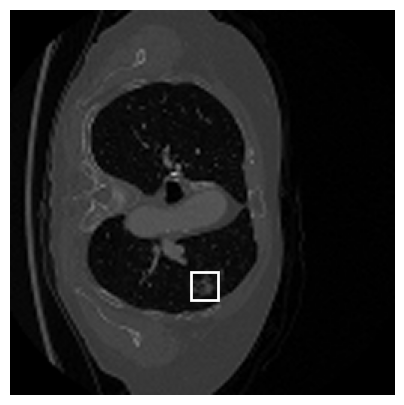

In [57]:
plt.figure(figsize=(5, 5))
plt.imshow(images[14])
show_box(input_box[0], plt.gca())
plt.axis('off')
plt.show()

In [28]:
x0, y0 = input_box[0][0], input_box[0][1]
x1, y1 = input_box[0][2], input_box[0][3]

In [29]:
x0

100

In [24]:
# mask_box = cv2.rectangle(mask, (x0,y0), (x1, y1), (0, 0, 0) , 2) 
# mask_box = cv2.rectangle(cv2.cvtColor(mask*255,cv2.COLOR_GRAY2BGR), (x0,y0), (x1, y1), (255, 0, 0) , 2) 
  
# Displaying the image  
# cv2.imshow("mask with box", mask_box)  

In [25]:
# masks, scores, logits = mask_predictor.predict(
#     point_coords=input_point,
#     point_labels=input_label,
#     multimask_output=True,
# )
# # masks = masks.sum(axis = 0).cpu().numpy()

In [26]:
masks.shape

(1, 1, 256, 256)

In [27]:
box_scores = box_scores.cpu().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [ ]:
scores

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [ ]:
box_mask.shape

In [ ]:
new_masks = np.concatenate((masks, box_mask), axis=0)
new_scores = np.concatenate((scores, box_scores[0]))

In [ ]:
avg_mask = sum(new_masks)/len(new_masks)
avg_mask = np.expand_dims(avg_mask, axis=0)
avg_mask = np.array(avg_mask>0.9, dtype=np.float64)
avg_mask.shape

In [ ]:
all_masks = np.concatenate((new_masks, avg_mask), axis=0)
all_masks.shape

In [ ]:
all_scores = np.concatenate((new_scores, np.array([1.])))

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
# mask_annotator = sv.MaskAnnotator(color=sv.Color.red())
# mask_annotator = sv.MaskAnnotator(color=sv.Color(r=255, g=0, b=0))
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup="INDEX")

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=box_mask),
    mask=box_mask
)
detections = detections[detections.area == np.max(detections.area)]

# source_image = box_annotator.annotate(scene=resized_image.copy(), detections=detections, skip_label=True)
# segmented_image = mask_annotator.annotate(scene=resized_image.copy(), detections=detections)

source_image = box_annotator.annotate(scene=image.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image.copy(), detections=detections)


In [ ]:
sv.plot_images_grid(
    # images=[source_image, segmented_image, mask[0], resized_mask],
    images=[image, segmented_image, mask, gt_mask],
    grid_size=(1, 4),
    titles=['source image', 'segmented image', 'mask', 'gt_mask']
)

In [ ]:
images = []
masks=[]
i = 0
num =0

while i < len(df) and num <5:
    mask = cv2.imread(df["masks"][i])
    if mask.sum() != 0:
        masks.append(mask)
        images.append(cv2.imread(df["images"][i]))        
        num+=1
    i+=1

In [ ]:
sv.plot_images_grid(
    images=images,
    grid_size=(1, len(images)),
)

sv.plot_images_grid(
    images=masks,
    grid_size=(1, len(masks)),
)

In [ ]:
masks[0].shape

In [ ]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device) 
    return image.permute(2, 0, 1).contiguous()

In [ ]:
# batched_input = [
#      {
#          'image': prepare_image(images[0], resize_transform, DEVICE),
#          'boxes': getBoxes(images[0], masks[0]),
#          'original_size': images[0].shape[:2]
#      },
#      {
#          'image': prepare_image(images[1], resize_transform, DEVICE),
#          'boxes': getBoxes(images[1], masks[1]),
#          'original_size': images[1].shape[:2]
#      }
# ]

In [ ]:
def getBatch(images, masks):
    return [{"image": prepare_image(image, resize_transform, DEVICE),
             "boxes": getBoxes(image, mask),
             "original_size": image.shape[:2]} for image, mask in zip(images, masks)]

In [ ]:
batch = getBatch(images, masks)

In [ ]:
len(batch)

In [ ]:
# batched_output = sam(batched_input, multimask_output=False)
batched_output = sam(batch, multimask_output=False)


In [ ]:
batched_output[0].keys()
output_masks=[]
for i in range(len(batched_output)):
    for mask in batched_output[i]["masks"]:
        mask = mask.sum(axis = 0).cpu().numpy()
        output_masks.append(mask)

In [ ]:
output_masks[0].shape

In [ ]:
import torch.nn.functional as F
out = torch.rand((256, 1, 256, 256))
prob = F.sigmoid(out)

In [ ]:
sv.plot_images_grid(
    images=output_masks,
    grid_size=(1, 2),
)

In [ ]:
# box_annotator = sv.BoxAnnotator(color=sv.Color.red())
# # mask_annotator = sv.MaskAnnotator(color=sv.Color.red())
# # mask_annotator = sv.MaskAnnotator(color=sv.Color(r=255, g=0, b=0))
# mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup="INDEX")

# detections = sv.Detections(
#     xyxy=sv.mask_to_xyxy(masks=mask),
#     mask=mask
# )
# detections = detections[detections.area == np.max(detections.area)]

# source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
# segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# sv.plot_images_grid(
#     images=[source_image, segmented_image],
#     grid_size=(1, 2),
#     titles=['source image', 'segmented image']
# )

In [ ]:
# import supervision as v

# sv.plot_images_grid(
#     images=mask,
#     grid_size=(1, 2),
#     size=(16, 4)
# )

In [ ]:
# os.makedirs("../data/processed/masks+/", exist_ok = True)
# np.save('../data/processed/masks+/{}.npy'.format(filenames[i].split('.png')[0]), mask)

In [ ]:
class SAMOracle():
    
    def __init__(self,
                 device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                 model_type = "vit_h",
                 checkpoint_path = os.path.join("../sam","sam_vit_h_4b8939.pth"),
                 model = None,
                 default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}
                ):
        
        self.device = device
        self.model_type = model_type
        self.checkpoint_path = checkpoint_path
        self.model = sam_model_registry[model_type](checkpoint=checkpoint_path).to(device=device)
        self.mask_predictor = SamPredictor(self.model)
        self.default_box = default_box        
        
        
    
    def get_mask(self, img_path = None, img_rgb=None, boxes=None):
        
        if img_rgb is None:
            image_bgr = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
            
        self.mask_predictor.set_image(img_rgb)
        
        if boxes is None:
            widget = BBoxWidget()
            widget.image = encode_image(img_path)
            boxes = []
            for box in widget.bboxes:
                box = np.array([
                    box['x'], 
                    box['y'], 
                    box['x'] + box['width'], 
                    box['y'] + box['height']
                ])
                boxes.append(box)
            boxes.append(np.array([
                        self.default_box['x'],
                        self.default_box['y'],
                        self.default_box['x'] + self.default_box['width'],
                        self.default_box['y'] + self.default_box['height']]))
            boxes = torch.Tensor(boxes).to(self.device)
        transformed_boxes = self.mask_predictor.transform.apply_boxes_torch(boxes, img_rgb.shape[:2])


        masks, scores, logits = self.mask_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes=transformed_boxes,
            multimask_output=False
        )
        mask = masks.sum(axis = 0).cpu().numpy()
        return mask
    
    def annotate_mask(self, img_path:str):
        widget = BBoxWidget()
        widget.image = encode_image(img_path)
        boxes = []
        for box in widget.bboxes:
            box = np.array([
                box['x'], 
                box['y'], 
                box['x'] + box['width'], 
                box['y'] + box['height']
            ])
            boxes.append(box)
        boxes.append(np.array([
                    self.default_box['x'],
                    self.default_box['y'],
                    self.default_box['x'] + self.default_box['width'],
                    self.default_box['y'] + self.default_box['height']]))
        boxes = torch.Tensor(boxes).to(self.device)

        image_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        mask_annotator = sv.MaskAnnotator(color=sv.Color.red())
        mask = self.get_mask(img_rgb=img_rgb, boxes=boxes)
        detections = sv.Detections(xyxy=sv.mask_to_xyxy(masks=mask),
                                   mask=mask)
        
        detections = detections[detections.area == np.max(detections.area)]

        segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
        return segmented_image